# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [1]:
! git clone https://www.github.com/Ceerogreen/assignment4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fatal: destination path 'assignment4' already exists and is not an empty directory.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [2]:
cars = pd.read_csv('/content/assignment4/data/cars_hw.csv')
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)
cars['Price'] = maxmin(cars['Price'])
cars['Mileage_Run'] = maxmin(cars['Mileage_Run'])
cars['Age'] = max(cars['Make_Year']) - cars['Make_Year']
cars['Age'] = maxmin(cars['Age'])
cars['Price_ihs'] = np.arcsinh(cars['Price'])
cars['No_of_Owners'] = cars['No_of_Owners'].str.strip('stndr')
cars['No_of_Owners'] = pd.to_numeric(cars['No_of_Owners'])
cars['No_of_Owners'] = maxmin(cars['No_of_Owners'])
cars['Seating_Capacity'] = maxmin(cars['Seating_Capacity'])
for item in ['Price_ihs','Mileage_Run','Age']:
  Q1 = cars[item].quantile(0.25)
  Q3 = cars[item].quantile(0.75)
  IQR = Q3 - Q1
  cars = cars[(cars[item] > Q1 - 1.5 * IQR) & (cars[item] < Q3 + 1.5 * IQR)]
cars['Make'].unique()
cars.shape

(923, 14)

In [3]:
for item in ['Color','Body_Type','Make','Fuel_Type','Transmission','Transmission_Type']:
  counts = cars[item].value_counts()

  cars = cars[~cars[item].isin(counts[counts < 15].index)]


count    840.000000
mean       0.176314
std        0.088757
min        0.017798
25%        0.102165
50%        0.167397
75%        0.231225
max        0.448654
Name: Price_ihs, dtype: float64


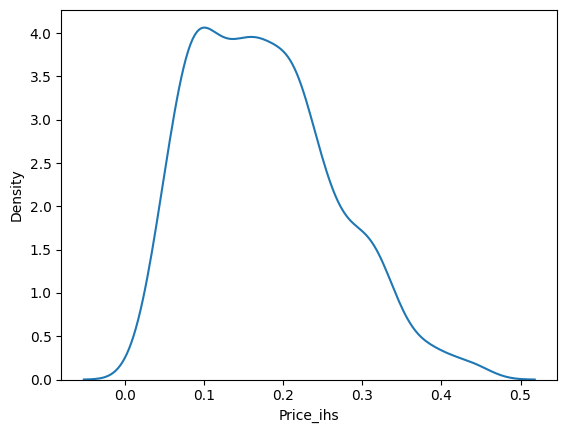

              Price_ihs                                                    \
                  count      mean       std       min       25%       50%   
Make                                                                        
Ford               49.0  0.196098  0.046146  0.120666  0.164531  0.187779   
Honda              70.0  0.217077  0.090001  0.046478  0.142003  0.216254   
Hyundai           290.0  0.178569  0.094732  0.021793  0.107764  0.162739   
Mahindra           18.0  0.325006  0.060293  0.219093  0.303699  0.323594   
Maruti Suzuki     280.0  0.145636  0.077107  0.017798  0.082272  0.124091   
Renault            57.0  0.178621  0.074386  0.059899  0.109119  0.185280   
Toyota             49.0  0.218151  0.087796  0.065337  0.115255  0.253717   
Volkswagen         27.0  0.148726  0.043552  0.077655  0.124991  0.137956   

                                   
                    75%       max  
Make                               
Ford           0.215900  0.313752  
Honda   

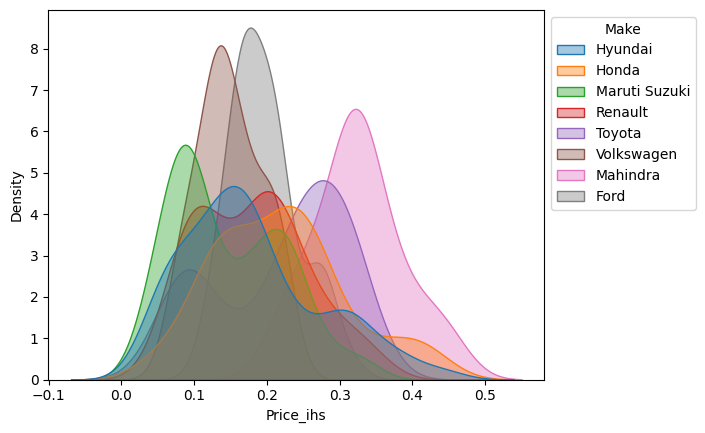

In [4]:
print(cars['Price_ihs'].describe())
sns.kdeplot(data=cars,x='Price_ihs')
plt.show()
print(cars[['Price_ihs','Make']].groupby(by=cars['Make']).describe())
ax = sns.kdeplot(data=cars, x='Price_ihs', hue='Make', fill=True, common_norm=False, alpha=0.4)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.show()
# Mahindra, Toyotas, Tatas and Hondas are the most expensive on average; The data tends to be close to
# normally distributed

In [5]:
X = cars.drop(columns=['Price','Price_ihs','Make_Year'],axis=1)
y = cars['Price_ihs']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

variables = ['Age','Mileage_Run','Seating_Capacity','No_of_Owners']

X3 = X_train.loc[:,variables]
X3t = X_test.loc[:,variables]
reg = LinearRegression().fit(X3, y_train)
print(reg.intercept_)
print(reg.coef_)
prediction = reg.predict(X_test.loc[:,variables])
print('R-squared: ' + str(r2_score(y_test,prediction)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,prediction))))

0.23155458038323928
[-0.23305642  0.08643867  0.06645137 -0.01115461]
R-squared: 0.3873313756053215
RMSE: 0.07344702055749748


In [7]:
catvars = ['Color','Body_Type','Make','Fuel_Type','Transmission','Transmission_Type']
X_2 = X_train.loc[:,catvars]
X_2_encoded = pd.get_dummies(X_2, columns=catvars)
X_2t = X_test.loc[:,catvars]
X_2t_encoded = pd.get_dummies(X_2t, columns=catvars)

reg2 = LinearRegression().fit(X_2_encoded, y_train)

print(reg2.intercept_)
print(reg2.coef_)
prediction = reg2.predict(X_2t_encoded)
print('R-squared: ' + str(r2_score(y_test,prediction)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,prediction))))

# The categorical data performs better than the numerical data

-90750548433.5515
[ 1.43214819e+12  1.43214819e+12  1.43214819e+12  1.43214819e+12
  1.43214819e+12  1.43214819e+12  1.43214819e+12  1.43214819e+12
  2.89587485e+11  2.89587485e+11  2.89587485e+11  2.89587485e+11
  2.89587485e+11 -1.19461381e+09 -1.19461381e+09 -1.19461381e+09
 -1.19461381e+09 -1.19461381e+09 -1.19461381e+09 -1.19461381e+09
 -1.19461381e+09 -3.29917410e+11 -3.29917410e+11 -1.21959094e+12
 -1.21959094e+12 -1.21959094e+12 -8.02821695e+10 -8.02821695e+10]
R-squared: 0.5919000744398303
RMSE: 0.059943848322623644


In [8]:
full_X_train = pd.concat([X3,X_2_encoded],axis=1)
full_X_test = pd.concat([X3t,X_2t_encoded],axis=1)

reg3 = LinearRegression().fit(full_X_train, y_train)

print(reg3.intercept_)
print(reg3.coef_)
prediction = reg3.predict(full_X_test)
print('R-squared: ' + str(r2_score(y_test,prediction)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,prediction))))

# Combined, this performs better than the numerical or categorical data alone

4612614562462.22
[-1.60854112e-01 -1.49366371e-02 -9.30833669e-02  2.26170260e-02
 -1.41529175e+12 -1.41529175e+12 -1.41529175e+12 -1.41529175e+12
 -1.41529175e+12 -1.41529175e+12 -1.41529175e+12 -1.41529175e+12
  3.08500581e+11  3.08500581e+11  3.08500581e+11  3.08500581e+11
  3.08500581e+11  4.53416748e+10  4.53416748e+10  4.53416748e+10
  4.53416748e+10  4.53416748e+10  4.53416748e+10  4.53416748e+10
  4.53416748e+10 -4.92449696e+11 -4.92449696e+11  1.36647210e+12
  1.36647210e+12  1.36647210e+12 -4.42518747e+12 -4.42518747e+12]
R-squared: 0.6498717838570284
RMSE: 0.05552325501971208


In [9]:
from sklearn.preprocessing import PolynomialFeatures
for i in range(2,10):
  expander = PolynomialFeatures(degree=i,include_bias=False)
  X3Ex = expander.fit_transform(X3)
  names = expander.get_feature_names_out()
  X3Expanded = pd.DataFrame(data=X3Ex, columns = names, index=X3.index)

  X3tEx = expander.fit_transform(X3t)
  names = expander.get_feature_names_out()
  X3tExpanded = pd.DataFrame(data=X3tEx, columns = names, index=X3t.index)

  full_X_train2 = pd.concat([X3Expanded,X_2_encoded],axis=1)
  full_X_test2 = pd.concat([X3tExpanded,X_2t_encoded],axis=1)

  reg4 = LinearRegression().fit(full_X_train2, y_train)

  print('Expander = ' + str(i))
  prediction = reg4.predict(full_X_test2)
  print('R-squared: ' + str(r2_score(y_test,prediction)))
  print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,prediction))))

# at Polynomial degree 6, the R-squared value goes negative. Expander 2 is much better than no expander, but it slowly gets worse from there.
# The best is at polynomial degree 2, where the R-squared is 0.803 and the RMSE is 0.0417

Expander = 2
R-squared: 0.8028129637081707
RMSE: 0.041667797293046496
Expander = 3
R-squared: 0.8003345734677456
RMSE: 0.04192883523253742
Expander = 4
R-squared: 0.7998926174798793
RMSE: 0.041975213959951185
Expander = 5
R-squared: 0.7298215935287704
RMSE: 0.04877380985465596
Expander = 6
R-squared: -223869422073.57742
RMSE: 44397.5241321954
Expander = 7
R-squared: -473326041550053.9
RMSE: 2041463.2324785998
Expander = 8
R-squared: -4638792391234256.0
RMSE: 6390926.618941058
Expander = 9
R-squared: -1333816563345932.2
RMSE: 3426963.0040092673


R-squared: 0.8028129637081707
RMSE: 0.041667797293046496


<Axes: ylabel='Price_ihs'>

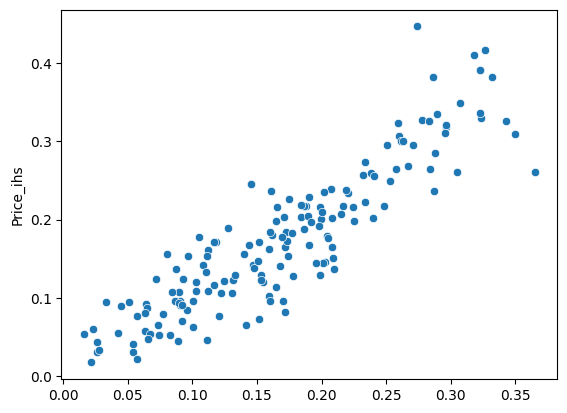

In [10]:
# Best Regression:
expander = PolynomialFeatures(degree=2,include_bias=False)
X3Ex = expander.fit_transform(X3)
names = expander.get_feature_names_out()
X3Expanded = pd.DataFrame(data=X3Ex, columns = names, index=X3.index)

X3tEx = expander.fit_transform(X3t)
names = expander.get_feature_names_out()
X3tExpanded = pd.DataFrame(data=X3tEx, columns = names, index=X3t.index)

full_X_train2 = pd.concat([X3Expanded,X_2_encoded],axis=1)
full_X_test2 = pd.concat([X3tExpanded,X_2t_encoded],axis=1)

reg4 = LinearRegression().fit(full_X_train2, y_train)
prediction = reg4.predict(full_X_test2)
print('R-squared: ' + str(r2_score(y_test,prediction)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,prediction))))

sns.scatterplot(x=prediction,y=y_test)

# This is very much in a linear pattern

<Axes: xlabel='Price_ihs', ylabel='Density'>

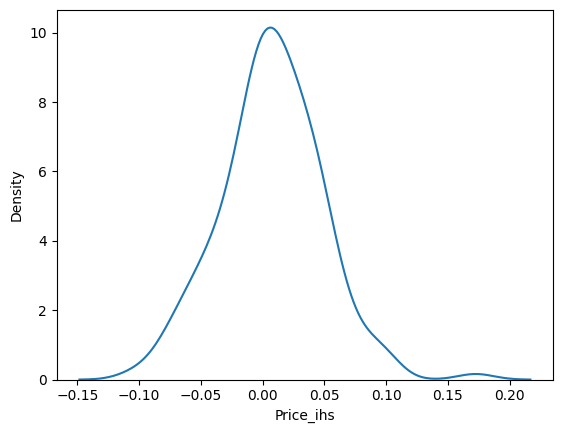

In [11]:
residuals = y_test - prediction
sns.kdeplot(residuals)

# The residuals are mostly normal, with a slight skew to the right. Overall, this looks to be a very strong model, with the strong caveat that
# There is likely overfitting due to the removal of categorical variables with few (<15) data points. These were causing issues with the hot
# one encoding due to not appearing in both the training and test split, so I removed them; I also figured there was not enough data to make
# sound conclusions on these values' effects on price. This is the biggest weakness of my model

In [12]:
from sklearn import tree

In [18]:
for i in range(10,20):
  model = tree.DecisionTreeRegressor(max_depth=i) # Fit the classifier
  cart = model.fit(full_X_train, y_train)

  y_hat_cart = cart.predict(full_X_test)
  r2 = r2_score(y_test,y_hat_cart)

  print('Max Depth: ' + str(i))
  print('R-squared: ' + str(r2))
  print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test,y_hat_cart))))

# Max Depth of 16 gives the best performance, with an r^2 of 0.802 and an RMSE of 0.0418

Max Depth: 10
R-squared: 0.7895656455813164
RMSE: 0.04304469985360547
Max Depth: 11
R-squared: 0.7815828072454634
RMSE: 0.04385355177492548
Max Depth: 12
R-squared: 0.7832813658693796
RMSE: 0.043682701645648456
Max Depth: 13
R-squared: 0.7726721368504013
RMSE: 0.044739146812890485
Max Depth: 14
R-squared: 0.7892088668996227
RMSE: 0.043081174238750714
Max Depth: 15
R-squared: 0.7962155646585904
RMSE: 0.04235911404268231
Max Depth: 16
R-squared: 0.8042615842044814
RMSE: 0.041514460404007344
Max Depth: 17
R-squared: 0.7997872960569576
RMSE: 0.04198625879911068
Max Depth: 18
R-squared: 0.7965121916891602
RMSE: 0.04232827401838634
Max Depth: 19
R-squared: 0.7999047056757194
RMSE: 0.04197394611000105


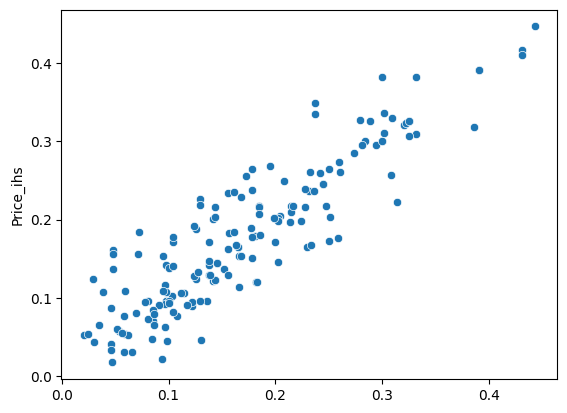

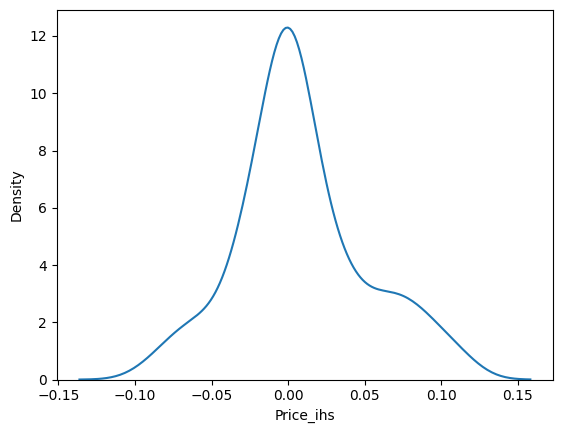

In [19]:
model = tree.DecisionTreeRegressor(max_depth=16) # Fit the classifier
cart = model.fit(full_X_train, y_train)

y_hat_cart = cart.predict(full_X_test)
r2 = r2_score(y_test,y_hat_cart)
rmse = np.sqrt(mean_squared_error(y_test,y_hat_cart))

tree_residuals = y_test - y_hat_cart
sns.scatterplot(x=y_hat_cart,y=y_test)
plt.show()
sns.kdeplot(tree_residuals)
plt.show()

# The graph is very close to linear, and the kernel density plot is approximately normal with a little rightward skew

In [ ]:
# The models actually performed quite similarly well numerically, though I imagine they skew in different ways that are impossible to tell
# just from this cursory look. They are both ever so slightly above an r^2 of 0.8 with an RMSE near 0.041. Both are good models that strongly
# predict the data.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

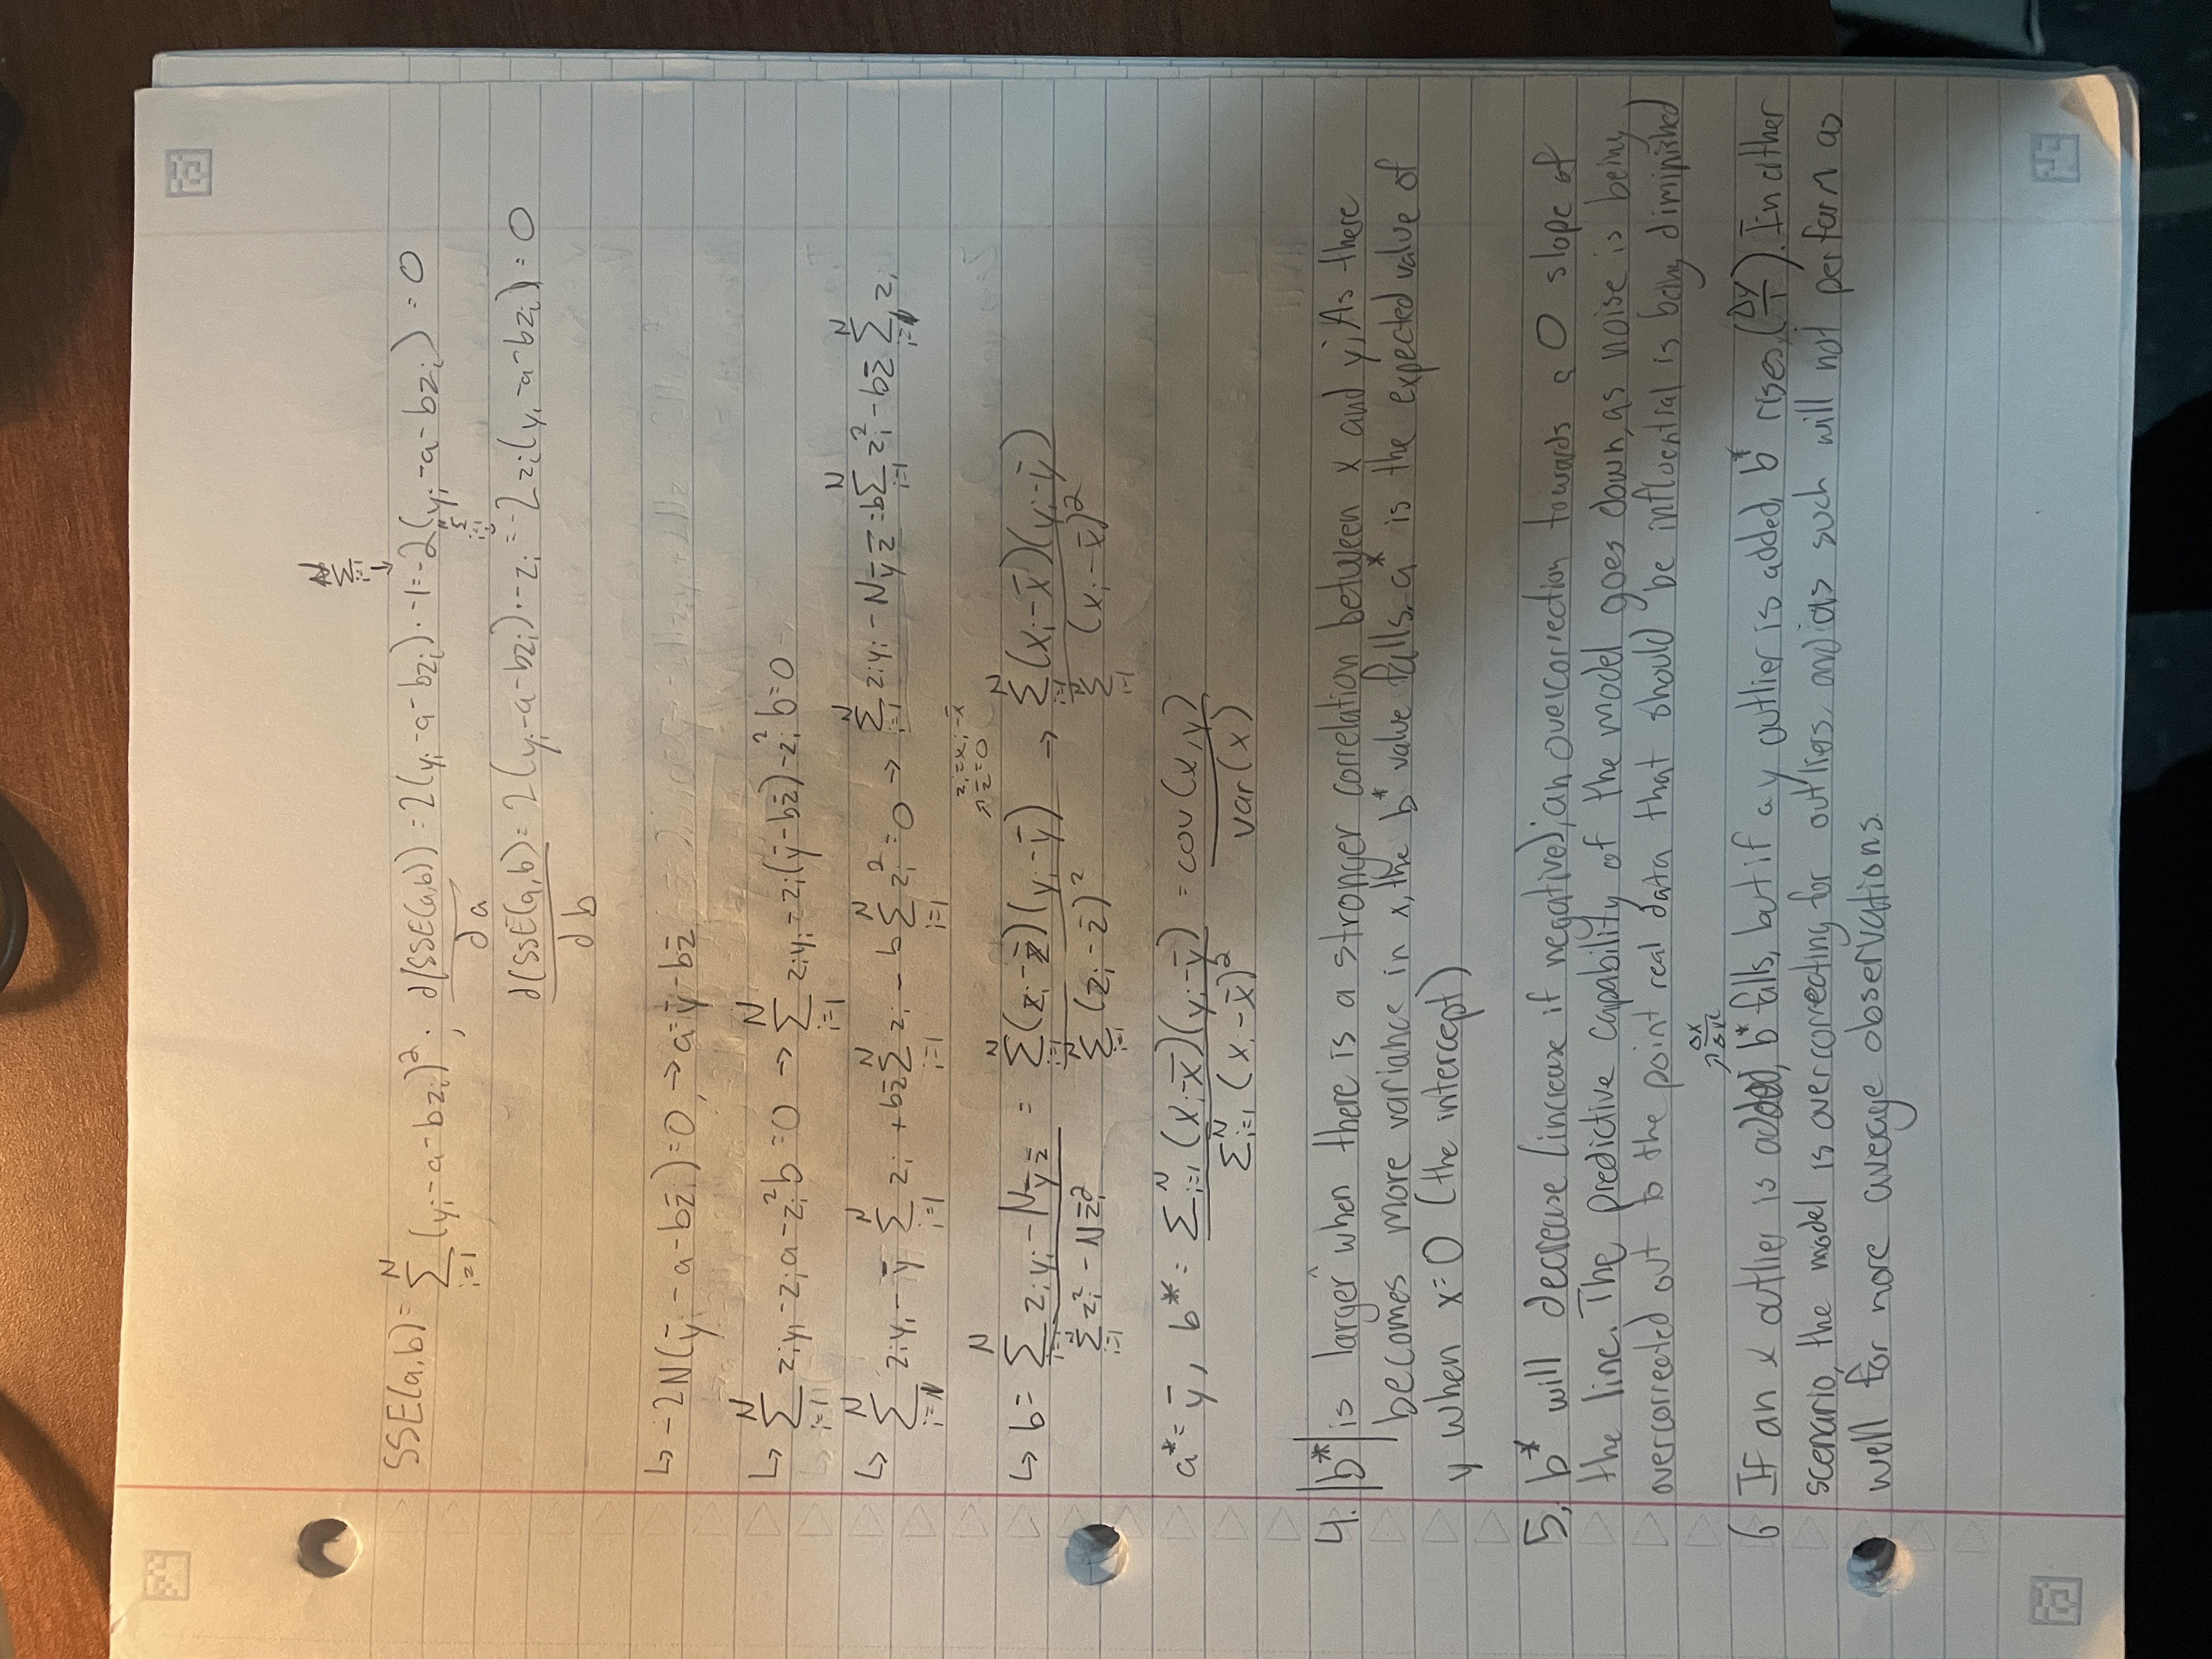

In [20]:
from IPython.display import Image
Image(filename='/content/assignment4/Q5.jpg')